# Лабораторная работа №6. Применение сверточных нейронных сетей (многоклассовая классификация)

**Данные:**

Набор данных для распознавания языка жестов, который состоит из изображений размерности 28x28 в оттенках серого (значение пикселя от 0 до 255). Каждое из изображений обозначает букву латинского алфавита, обозначенную с помощью жеста, как показано на рисунке ниже (рисунок цветной, а изображения в наборе данных в оттенках серого). Обучающая выборка включает в себя 27,455 изображений, а контрольная выборка содержит 7172 изображения. Данные в виде csv-файлов можно скачать на сайте Kaggle -> https://www.kaggle.com/datamunge/sign-language-mnist

In [0]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pdb;

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

Если файлы недоступны перезалейте их на сайте anonfile.

(или перейдите по ссылкам ниже и скопируйте ссылку приаттаченную на кнопке download)
Note: если 

In [0]:
import pathlib
import zipfile

# data_file_path = tf.keras.utils.get_file(origin='https://filebin.net/59yrr2otsk1mvs3o/sign-language-mnist.zip?t=1yv02e00',
#                                          fname='sign-language-mnist.zip', cache_dir='/content')

# with zipfile.ZipFile(data_file_path, 'r') as zip_ref:
#     zip_ref.extractall('./datasets/')

train_file_path = tf.keras.utils.get_file("train.csv", 'https://filebin.net/59yrr2otsk1mvs3o/sign_mnist_train.csv?t=k3gyhikl', cache_dir='/content')
test_file_path = tf.keras.utils.get_file("test.csv", 'https://filebin.net/59yrr2otsk1mvs3o/sign_mnist_test.csv?t=kgemko44', cache_dir='/content')

# train_file_path = tf.keras.utils.get_file("train.csv", 'https://cdn-32.anonfile.com/r5i8T6l8ob/29561bfd-1586126844/sign_mnist_train.csv', cache_dir='/content')
# test_file_path = tf.keras.utils.get_file("test.csv", 'https://cdn-33.anonfile.com/x2heT9l2oc/20e24ecc-1586126843/sign_mnist_test.csv', cache_dir='/content')

# train_df_full = pd.read_csv('./datasets/sign_mnist_train.csv')
# test_df = pd.read_csv('./datasets/sign_mnist_test.csv')

train_df_full = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [0]:
IMAGE_HEIGHT, IMAGE_WIDTH = 28, 28

In [0]:
import random
import datetime
from keras_preprocessing.image import DataFrameIterator

class Model:
    EPOCH_COUNT = 10
    
    def __init__(self, layers=[], model=None, optimizer=None):
        self.layers = layers
        self.model = model
        self.optimizer = optimizer or tf.keras.optimizers.SGD(
            learning_rate=0.1
        )
        if not self.model:
            self.initialize()
        print('----------------------------------------------------------------------------------------')
        print(self.summary())
        print('----------------------------------------------------------------------------------------')

    def initialize(self):
        self.model = tf.keras.models.Sequential(self.layers)
        self.model.compile(optimizer=self.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    def _train_on_batches(self, iterator, batch_count, epochs=None, **kwargs):
        epochs = epochs or self.EPOCH_COUNT
        loss, tran_accuracy, val_accuracy = np.zeros((3, batch_count, epochs))

        for i in range(batch_count):
            print('----------------------------------------------------------------------------------------')
            print(f'Train on batch #{i}')
            print('----------------------------------------------------------------------------------------')
            x, y = next(iterator)
            batch_history = self.model.fit(x,  y, epochs=epochs, **kwargs)
            loss[i, :] = batch_history.history['loss']
            tran_accuracy[i, :] = batch_history.history['accuracy']
            if batch_history.history.get('val_accuracy'):
                val_accuracy[i, :] = batch_history.history.get('val_accuracy')[-1]

        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_accuracy

    def _train_on_full_data(self, iterator, epochs=None, **kwargs):
        print('----------------------------------------------------------------------------------------')
        print(f'Train on full data')
        print('----------------------------------------------------------------------------------------')
        epochs = epochs or self.EPOCH_COUNT
        history = self.model.fit(iterator, epochs=epochs, **kwargs)
        loss = np.array([history.history['loss']])
        tran_accuracy = np.array([history.history['accuracy']])
        val_accuracy = np.array([history.history.get('val_accuracy')])

        val_accuracy = val_accuracy if np.any(val_accuracy) else None

        return loss, tran_accuracy, val_accuracy

    def _plot_train_accuracy_graphs(self, loss, tran_accuracy, mode='batch'):
        print('----------------------------------------------------------------------------------------')
        if mode == 'batch':
            plt.figure(figsize=(15, 12))
            ax_shape = (2, 2)
        else:
            plt.figure(figsize=(15,5))
            ax_shape = (1, 2)

        epochs_loss = np.average(loss, axis=0)
        xlabel = 'Epochs'
        ax = plt.subplot(*ax_shape, 1)
        ax.plot(epochs_loss)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)

        epochs_accuracy = np.average(tran_accuracy, axis=0)
        ax = plt.subplot(*ax_shape, 2)
        ax.plot(epochs_accuracy)
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)

        if mode == 'batch':
            batches_loss = np.average(loss, axis=1)
            xlabel = 'Batches'
            ax = plt.subplot(*ax_shape, 3)
            ax.plot(batches_loss)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Loss', fontsize=14)

            batches_accuracy = np.average(tran_accuracy, axis=1)
            ax = plt.subplot(*ax_shape, 4)
            ax.plot(batches_accuracy)
            ax.set_xlabel(xlabel, fontsize=14)
            ax.set_ylabel('Accuracy', fontsize=14)
        
        plt.show()

    def _show_train_result(self, spent_time, average_loss, average_tran_accuracy, val_accuracy=None):
        print('----------------------------------------------------------------------------------------')
        print('Spent time:', spent_time)
        print('Average loss error:', average_loss)
        print('Average train error:', average_tran_accuracy)
        if val_accuracy is not None:
            print('Average validation error:', val_accuracy)
        print('----------------------------------------------------------------------------------------')

    def train(self, iterator, batch_count=None, show_accuracy_graph=True, **kwargs):
        now = datetime.datetime.now()
        val_accuracy = None

        if batch_count:
            loss, tran_accuracy, val_accuracy =  self._train_on_batches(iterator, batch_count, **kwargs)
        else:
            print('----------------------------------------------------------------------------------------')
            print(f'Started at {now}')
            loss, tran_accuracy, val_accuracy =  self._train_on_full_data(iterator, **kwargs)

        if show_accuracy_graph:
            mode = 'batch' if batch_count else 'epoch'
            self._plot_train_accuracy_graphs(loss, tran_accuracy, mode=mode)


        average_loss = np.average(loss)
        average_tran_accuracy = np.average(tran_accuracy)
        average_val_accuracy = val_accuracy and np.average(val_accuracy)
        self._show_train_result(
            datetime.datetime.now() - now,
            average_loss,
            average_tran_accuracy,
            average_val_accuracy
        )

        return {'loss': loss, 'accuracy': tran_accuracy, 'val_accuracy': val_accuracy}

    def test(self, x_test, y_test=None, **kwargs):
        return self.model.evaluate(x_test,  y_test, **kwargs)
    
    def summary(self):
        return self.model.summary()

    def predict(self, data, **kwargs):
        return self.model.predict(data, **kwargs)

    def save(self, **kwargs):
        filedir = kwargs.pop('filedir', './')
        filepath = filedir + kwargs.pop('filename', self.model.name)
        tf.keras.models.save_model(self.model, filepath, **kwargs)

### Задание 1. Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.

In [0]:
BATCH_SIZE = 64

In [0]:
def create_dataset(df, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=BATCH_SIZE):
    el_count = len(df)
    df_y = df.label
    df_x = df.loc[:, df.columns != 'label']
    df_x *= 1/255
    df_x = np.reshape(df_x.values, (el_count, *target_size, 1))
    return tf.data.Dataset.from_tensor_slices((df_x, df_y.values)).shuffle(el_count).batch(batch_size)

In [0]:
train, validation = train_test_split(train_df_full, test_size=0.2)
train_df = pd.DataFrame(train)
validation_df = pd.DataFrame(validation)

In [0]:
train_dataset = create_dataset(train_df)
validation_dataset = create_dataset(validation_df)
test_dataset = create_dataset(test_df)

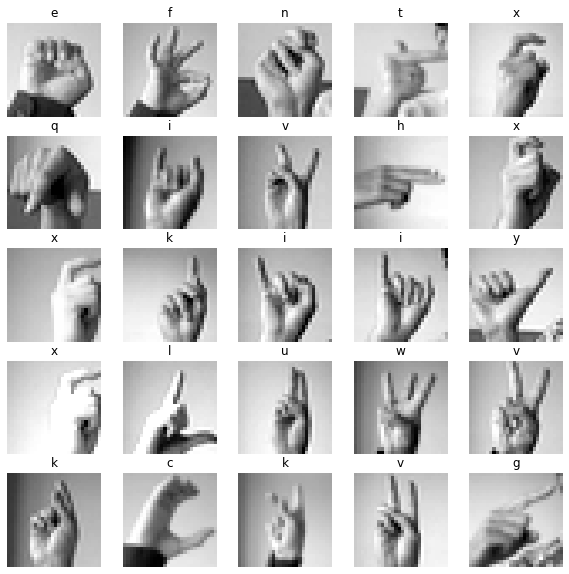

In [11]:
def show_samples_from_iterator(iterator):
    image_batch, label_batch = next(iterator)
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n, :, :, 0], cmap='gray')
        plt.title(chr(ord('a') + label_batch[n]))
        plt.axis('off')

show_samples_from_iterator(train_dataset.as_numpy_iterator())

### Задание 2.Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?


In [0]:
layers = [
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(25, activation='softmax'),
]

In [13]:
model = Model(layers=layers)

----------------------------------------------------------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________

----------------------------------------------------------------------------------------
Started at 2020-04-08 17:47:25.626148
----------------------------------------------------------------------------------------
Train on full data
----------------------------------------------------------------------------------------
Epoch 1/10
344/344 [==============================] - 1s 4ms/step - loss: 2.8284 - accuracy: 0.1403
Epoch 2/10
344/344 [==============================] - 1s 4ms/step - loss: 1.0986 - accuracy: 0.6380
Epoch 3/10
344/344 [==============================] - 1s 4ms/step - loss: 0.2772 - accuracy: 0.9129
Epoch 4/10
344/344 [==============================] - 1s 4ms/step - loss: 0.1163 - accuracy: 0.9748
Epoch 5/10
344/344 [==============================] - 1s 4ms/step - loss: 0.0067 - accuracy: 0.9998
Epoch 6/10
344/344 [==============================] - 1s 4ms/step - loss: 0.0029 - accuracy: 0.9999
Epoch 7/10
344/344 [==============================] - 1s 4ms/step - loss: 0.

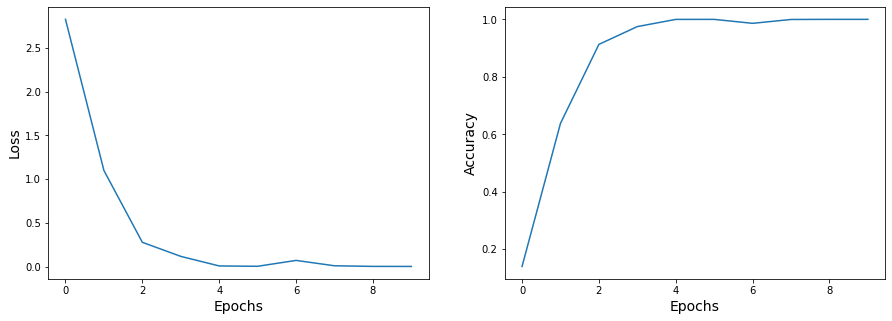

----------------------------------------------------------------------------------------
Spent time: 0:00:17.121245
Average loss error: 0.4411658042576164
Average train error: 0.8651429653167725
----------------------------------------------------------------------------------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/6/model/assets


In [14]:
with tf.device('/device:GPU:0'):
    history = model.train(train_dataset, epochs=10, workers=6)
    model.save(filedir='/content/drive/My Drive/Colab Notebooks/6/', filename='model')

In [15]:
model.test(validation_dataset)

86/86 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 1.0000


[0.0010314149549230933, 1.0]

In [16]:
history = model.test(test_dataset)

113/113 [==============================] - 0s 3ms/step - loss: 0.5869 - accuracy: 0.8781


### Задание 3. Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 

In [0]:
class AugmentationDataGenerator:
    AUGMENTATION_FUNCTIONS = ['_flip_up_down', '_flip_left_right', '_color', '_zoom', '_rotate']
    
    @classmethod
    def _flip_up_down(cls, x):
        return tf.image.random_flip_up_down(x)
    
    @classmethod
    def _flip_left_right(cls, x):
        return tf.image.random_flip_left_right(x)

    @classmethod
    def _color(cls, x):
        x = tf.image.random_brightness(x, 0.2)
        x = tf.image.random_contrast(x, 0.7, 1.3)
        return x

    @classmethod
    def _rotate(cls, x):
        return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    @classmethod
    def _zoom(cls, x):
        central_fraction = random.uniform(0.5, 0.9)
        cropped_x = tf.image.central_crop(x, central_fraction=central_fraction)
        return tf.image.resize(cropped_x, x.shape[:2], method='nearest')
    
    @classmethod
    def _create_dataset(cls, df, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=BATCH_SIZE, preprocess_x=None):
        el_count = len(df)
        df_y = df.label
        df_x = df.loc[:, df.columns != 'label']
        df_x *= 1/255
        np_x = np.reshape(df_x.values, (el_count, *target_size, 1))
        if preprocess_x:
            np_x = preprocess_x(np_x)
        return tf.data.Dataset.from_tensor_slices((np_x, df_y.values)).shuffle(el_count).batch(batch_size)

    @classmethod
    def generate(cls, df, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=BATCH_SIZE):
        def preprocess_x(np_x):
            for fun_name in cls.AUGMENTATION_FUNCTIONS:
                aug_function = getattr(cls, fun_name)
                for i in range(np_x.shape[0]):
                    if random.random() > 0.5:
                        np_x[i, :, :, :] = aug_function(np_x[i, :, :, :])
  
            return np_x

        return cls._create_dataset(df, target_size, batch_size, preprocess_x)

In [0]:
del train_dataset

In [0]:
aug_train_dataset = AugmentationDataGenerator.generate(train_df)

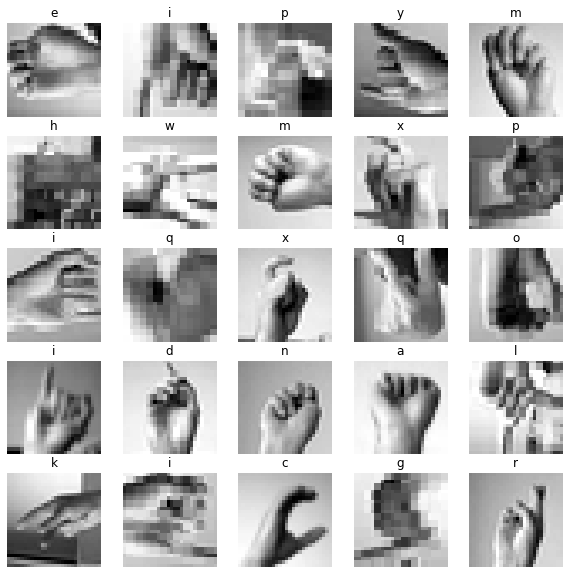

In [20]:
show_samples_from_iterator(aug_train_dataset.as_numpy_iterator())

----------------------------------------------------------------------------------------
Started at 2020-04-08 17:50:03.288976
----------------------------------------------------------------------------------------
Train on full data
----------------------------------------------------------------------------------------
Epoch 1/20
344/344 [==============================] - 1s 4ms/step - loss: 2.3770 - accuracy: 0.3312
Epoch 2/20
344/344 [==============================] - 1s 4ms/step - loss: 1.7440 - accuracy: 0.4714
Epoch 3/20
344/344 [==============================] - 1s 4ms/step - loss: 1.4446 - accuracy: 0.5533
Epoch 4/20
344/344 [==============================] - 1s 4ms/step - loss: 1.2300 - accuracy: 0.6144
Epoch 5/20
344/344 [==============================] - 1s 4ms/step - loss: 1.0265 - accuracy: 0.6751
Epoch 6/20
344/344 [==============================] - 1s 4ms/step - loss: 0.8960 - accuracy: 0.7167
Epoch 7/20
344/344 [==============================] - 1s 4ms/step - loss: 0.

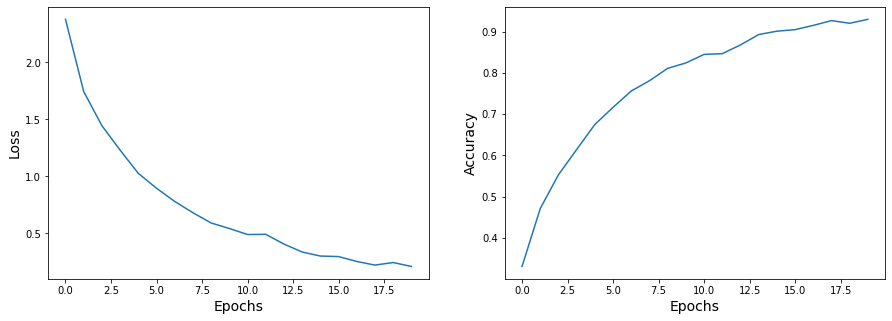

----------------------------------------------------------------------------------------
Spent time: 0:00:27.336610
Average loss error: 0.728304897993803
Average train error: 0.7742009714245797
----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/6/aug_model/assets


In [21]:
with tf.device('/device:GPU:0'):
    history = model.train(aug_train_dataset, epochs=20, workers=6)
    model.save(filedir='/content/drive/My Drive/Colab Notebooks/6/', filename='aug_model')

In [24]:
model.test(validation_dataset)

86/86 [==============================] - 0s 3ms/step - loss: 1.3274 - accuracy: 0.7893


[1.3273528814315796, 0.7892915606498718]

In [25]:
model.test(test_dataset)

113/113 [==============================] - 0s 3ms/step - loss: 2.3165 - accuracy: 0.6910


[2.3164522647857666, 0.6910206079483032]

In [0]:
del validation_dataset
del test_dataset

### Задание 4. Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него? Какой максимальный результат удалось получить на контрольной выборке?


#### VGG16

In [0]:
VGG16_IMAGE_HEIGHT = 48
VGG16_IMAGE_WIDTH = 48

def VGG16():
    # transform input layer (VGG16_IMAGE_HEIGHT, VGG16_IMAGE_WIDTH, 1) to (VGG16_IMAGE_HEIGHT, VGG16_IMAGE_WIDTH, 3)
    input_tesor = tf.keras.layers.Input(shape=(VGG16_IMAGE_HEIGHT, VGG16_IMAGE_WIDTH, 1))
    # conc_tensor = tf.keras.layers.Concatenate()([input_tesor, input_tesor, input_tesor]) 
    conc_tensor = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(input_tesor) 

    # load pretrained vgg16
    pretrain_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

    # Make vgg16 model layers as non trainable
    pretrain_model.trainable = False

    pretrain_model = pretrain_model(conc_tensor)

    # create custom output layer
    x = tf.keras.layers.Dropout(0.2)(pretrain_model)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    output_tensor = tf.keras.layers.Dense(25, activation='softmax')(x)
    

    # flatten_tensor = tf.keras.layers.Flatten()(pretrain_model.output)
    # output_tensor = tf.keras.layers.Dense(25, activation='softmax')(flatten_tensor)
    
    # gather layers and create model
    pretrain_model = tf.keras.Model(inputs=input_tesor, outputs=output_tensor)
    pretrain_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return pretrain_model

In [0]:
def create_dataset(df, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), target_size=(VGG16_IMAGE_HEIGHT, VGG16_IMAGE_WIDTH), batch_size=BATCH_SIZE, preprocess_x=None):
    el_count = len(df)
    df_y = df.label
    df_x = df.loc[:, df.columns != 'label']

    np_x = np.reshape(df_x.values, (el_count, *input_size, 1))
    np_x = np.true_divide(np_x, 255)
    np_x = tf.image.resize(np_x, target_size)
    # np_x = tf.keras.applications.vgg16.preprocess_input(np_x)
    return tf.data.Dataset.from_tensor_slices((np_x, df_y.values)).shuffle(el_count).batch(batch_size)

vgg166_train_dataset = create_dataset(train_df)
vgg166_validation_dataset = create_dataset(validation_df)
vgg166_test_dataset = create_dataset(test_df)

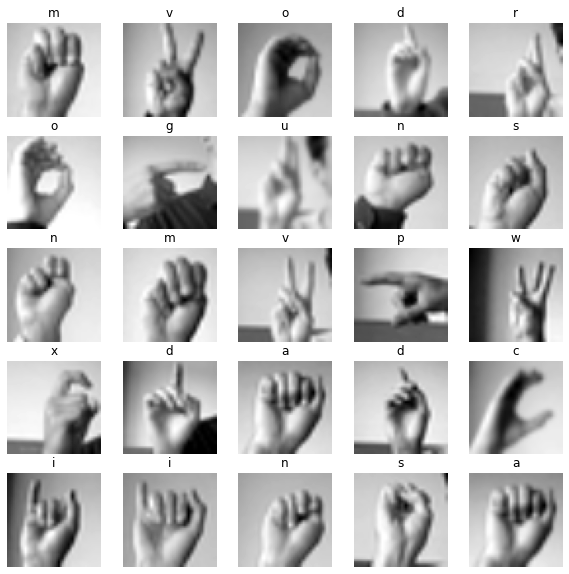

In [29]:
show_samples_from_iterator(iter(vgg166_train_dataset))

In [56]:
vgg16_model = Model(model=VGG16())

----------------------------------------------------------------------------------------
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 48, 48, 3)         30        
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              525312    
____________________________________

----------------------------------------------------------------------------------------
Started at 2020-04-08 18:32:29.405559
----------------------------------------------------------------------------------------
Train on full data
----------------------------------------------------------------------------------------
Epoch 1/15
344/344 [==============================] - 8s 25ms/step - loss: 0.0675 - accuracy: 0.9807
Epoch 2/15
344/344 [==============================] - 8s 25ms/step - loss: 0.0694 - accuracy: 0.9782
Epoch 3/15
344/344 [==============================] - 8s 24ms/step - loss: 0.0611 - accuracy: 0.9819
Epoch 4/15
344/344 [==============================] - 8s 24ms/step - loss: 0.0587 - accuracy: 0.9821
Epoch 5/15
344/344 [==============================] - 8s 24ms/step - loss: 0.0524 - accuracy: 0.9854
Epoch 6/15
344/344 [==============================] - 8s 24ms/step - loss: 0.0543 - accuracy: 0.9836
Epoch 7/15
344/344 [==============================] - 8s 24ms/step - l

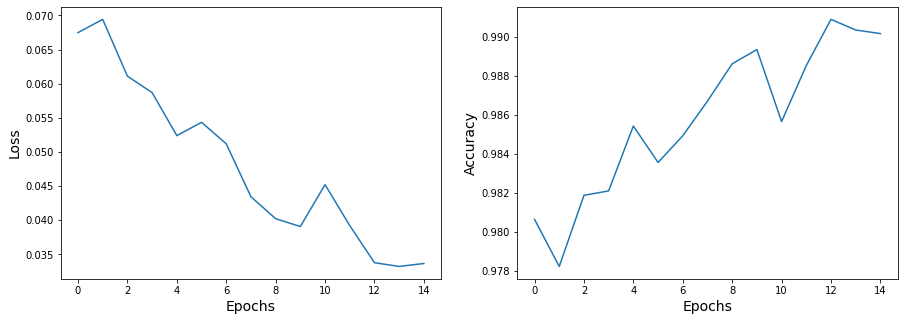

----------------------------------------------------------------------------------------
Spent time: 0:02:08.586911
Average loss error: 0.048171819746494295
Average train error: 0.985804041226705
----------------------------------------------------------------------------------------
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/6/vgg16_model/assets


In [62]:
# history = vgg16_model.train(vgg166_dataset, epochs=50, workers=6)
with tf.device('/device:GPU:0'):
    history = vgg16_model.train(vgg166_train_dataset, epochs=15, workers=4)
    vgg16_model.save(filedir='/content/drive/My Drive/Colab Notebooks/6/', filename='vgg16_model')

In [58]:
vgg16_model.test(vgg166_validation_dataset)

86/86 [==============================] - 1s 13ms/step - loss: 0.0146 - accuracy: 0.9982


[0.014646119438111782, 0.9981788396835327]

In [59]:
vgg16_model.test(vgg166_test_dataset)

113/113 [==============================] - 1s 13ms/step - loss: 0.1398 - accuracy: 0.9509


[0.1398414522409439, 0.9509202241897583]

In [0]:
del vgg166_validation_dataset
del vgg166_test_dataset

#### InceptionV3

In [0]:
INCEPTION_V3_IMAGE_HEIGHT = 299
INCEPTION_V3_IMAGE_WIDTH = 299

def InceptionV3():
    # trnsform input data (28, 28, 1) to (INCEPTION_V3_IMAGE_HEIGHT, INCEPTION_V3_IMAGE_WIDTH, 3)
    input_tesor = tf.keras.layers.Input(shape=(INCEPTION_V3_IMAGE_HEIGHT, INCEPTION_V3_IMAGE_WIDTH, 1))
    conc_tensor = tf.keras.layers.Concatenate()([input_tesor, input_tesor, input_tesor]) 

    # load pretrained inception3
    pretrain_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_tensor=conc_tensor)

    # Make inception3 model layers as non trainable
    for layer in pretrain_model.layers:
        layer.trainable = False

    # create custom output layer
    x = tf.keras.layers.Dropout(0.2)(pretrain_model.layers[-2].output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    output_tensor = tf.keras.layers.Dense(25, activation='softmax')(x)
    
    # gather layers and create model
    pretrain_model = tf.keras.Model(inputs=pretrain_model.inputs, outputs=output_tensor)
    pretrain_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return pretrain_model

In [0]:
def create_dataset(df, input_size=(IMAGE_HEIGHT, IMAGE_WIDTH), target_size=(INCEPTION_V3_IMAGE_HEIGHT, INCEPTION_V3_IMAGE_WIDTH), batch_size=BATCH_SIZE, preprocess_x=None):
    el_count = len(df)
    df_y = df.label
    df_x = df.loc[:, df.columns != 'label']

    np_x = np.reshape(df_x.values, (el_count, *input_size, 1))
    np_x = np.true_divide(np_x, 255)
    np_x = tf.image.resize(np_x, target_size)
    # np_x = tf.keras.applications.vgg16.preprocess_input(np_x)
    return tf.data.Dataset.from_tensor_slices((np_x, df_y.values)).shuffle(el_count).batch(batch_size)

inception_v3_train_dataset = create_dataset(train_df)
inception_v3_validation_dataset = create_dataset(validation_df)

In [0]:
show_samples_from_iterator(iter(inception_v3_train_dataset)

In [14]:
inception_v3_model = Model(model=InceptionV3())

----------------------------------------------------------------------------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 299, 299, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         concatenate[0][0]                
_____

In [0]:
inception_v3_model.test(inception_v3_validation_dataset)

----------------------------------------------------------------------------------------
Started at 2020-04-08 18:37:50.668607
----------------------------------------------------------------------------------------
Train on full data
----------------------------------------------------------------------------------------
Epoch 1/5
344/344 [==============================] - 45s 130ms/step - loss: 1.1060 - accuracy: 0.8729
Epoch 2/5
344/344 [==============================] - 52s 150ms/step - loss: 0.0060 - accuracy: 0.9996
Epoch 3/5
344/344 [==============================] - 52s 152ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 4/5
344/344 [==============================] - 53s 154ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 5/5
344/344 [==============================] - 54s 158ms/step - loss: 0.0013 - accuracy: 1.0000
----------------------------------------------------------------------------------------


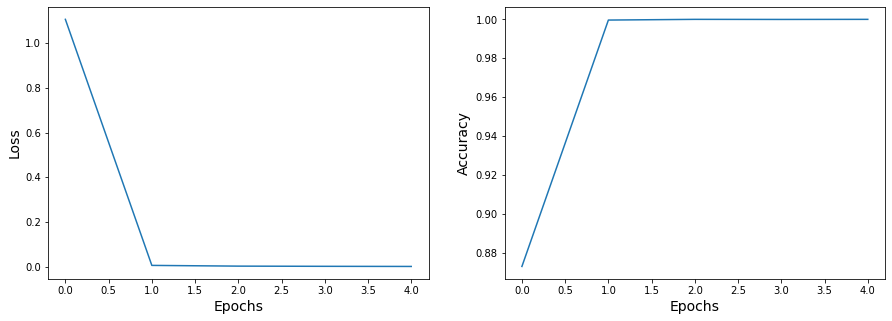

----------------------------------------------------------------------------------------
Spent time: 0:05:37.652218
Average loss error: 0.22356116976588963
Average train error: 0.9744946241378785
----------------------------------------------------------------------------------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/6/inception_v3_model/assets


In [16]:
with tf.device('/device:GPU:0'):
    history = inception_v3_model.train(inception_v3_train_dataset, epochs=5, workers=4)
    inception_v3_model.save(filedir='/content/drive/My Drive/Colab Notebooks/6/', filename='inception_v3_model')

In [18]:
inception_v3_model.test(inception_v3_validation_dataset)

86/86 [==============================] - 12s 136ms/step - loss: 0.0015 - accuracy: 1.0000


[0.0014849170111119747, 1.0]

In [0]:
inception_v3_test_dataset = create_dataset(test_df)

In [20]:
inception_v3_model.test(inception_v3_test_dataset)

113/113 [==============================] - 15s 130ms/step - loss: 0.0266 - accuracy: 0.9898


[0.026602501049637794, 0.9898215532302856]

#### Show layers

In [0]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

def display_layers(model, image, layers_count):
    # Let's define a new Model that will take an image as input, and will output
    # intermediate representations for all layers in the previous model after
    # the first.
    successive_outputs = [layer.output for layer in model.layers[1:]]

    #visualization_model = Model(img_input, successive_outputs)
    visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

    # Let's run our image through our network, thus obtaining all
    # intermediate representations for this image.
    successive_feature_maps = visualization_model.predict(image)

    # These are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in model.layers]

    # -----------------------------------------------------------------------
    # Now let's display our representations
    # -----------------------------------------------------------------------
    for layer_name, feature_map in list(zip(layer_names, successive_feature_maps))[:layers_count]:
        
        if len(feature_map.shape) == 4:
            
            #-------------------------------------------
            # Just do this for the conv / maxpool layers, not the fully-connected layers
            #-------------------------------------------
            n_features = feature_map.shape[-1]  # number of features in the feature map
            size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
                
            # We will tile our images in this matrix
            display_grid = np.zeros((size, size * n_features))
                
            #-------------------------------------------------
            # Postprocess the feature to be visually palatable
            #-------------------------------------------------
            for i in range(n_features):
                x  = feature_map[0, :, :, i]
                x -= x.mean()
                x /= x.std ()
                x *=  64
                x += 128
                x  = np.clip(x, 0, 255).astype('uint8')
                display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

            #-----------------
            # Display the grid
            #-----------------

            scale = 20. / n_features
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto') 

In [0]:
image = next(iter(vgg166_dataset))[0][2]

In [0]:
display_layers(VGG16(), np.reshape(image, (1, VGG16_IMAGE_HEIGHT, VGG16_IMAGE_WIDTH, 1)), 4)